In [64]:
import os
import sys
import logging
import traceback
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import GCNConv
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from time import time
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import optuna
from helper_functions import *


MAIN_PATH = "/dtu/3d-imaging-center/courses/02509/groups/group10/msc-hpc-run/"

# ---------------------------
# Global settings and seeding
# ---------------------------
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
pl.seed_everything(42)

# Global paths and constants
IMPORTS_PATH = os.path.join(MAIN_PATH, "data/import-volume.csv")
ADJACENCY_MATRIX = pd.read_parquet(os.path.join(MAIN_PATH, "data/adjacency-matrix.parquet"))
BOOKINGS_PATH = os.path.join(MAIN_PATH, "data/bookings_data.pkl")

# Global hyperparameters and settings
use_validation = False  
NODE_FEATURES = 21        # 6 from volume/week encoding + 13 booking features
TIME_WINDOW_SIZE = 13
LOADERS_WOKRES = 4

MIN_HORIZON = 1
MAX_HORIZON = 14

EARLY_STOP_PATIENCE = 7
EARLY_STOP_DELTA = 0.001

DIRECT_HORIZONS_TO_PREDICT = 13

# ---------------------------
# Data and Graph Preparation
# ---------------------------
def get_import_data():
    """Load and pivot the import volume data."""
    try:
        import_data = pd.read_csv(IMPORTS_PATH)
        import_data["week"] = pd.to_datetime(import_data["week"])
        import_data["pool"] = import_data["pool"].astype("str")
        import_data["volume"] = import_data["import"].astype("float")
        import_data.drop(columns=["import"], inplace=True)
        import_data = import_data.sort_values("week")
        import_data = import_data.loc[
            (import_data.week >= pd.to_datetime("2017-05-01")) &
            (import_data.week <= pd.to_datetime("2024-10-20"))
        ]
        logging.info(f"Imports data range from {import_data['week'].min().strftime('%Y-%m-%d')} "
                     f"to {import_data['week'].max().strftime('%Y-%m-%d')}")
        import_data = import_data.pivot(index='week', columns='pool', values='volume').T
        import_data = import_data.fillna(0)
        return import_data
    except Exception as e:
        logging.error("Error in get_import_data(): " + str(e))
        raise

def get_graph_structure(threshold, a):
    """Construct the graph structure (edge_index and edge_weights) from the adjacency matrix."""
    try:
        a = a.reset_index(drop=True)
        a.columns = range(a.shape[1])
        a = a.where(pd.notnull(a), a.T)
        a = a.to_numpy()
        a_filtered = (a > threshold).astype(np.int32)
        edge_index = torch.nonzero(torch.tensor(a_filtered, dtype=torch.long), as_tuple=False).t()
        edge_weights = []
        for e in edge_index.numpy().T:
            distance = a[e[0], e[1]]
            edge_weights.append(distance)
        edge_weights = torch.tensor(edge_weights, dtype=torch.float32)
        # epsilon = 1e-8
        # edge_weights = 10 / (edge_weights + epsilon)
        return edge_index, edge_weights
    except Exception as e:
        logging.error("Error in get_graph_structure(): " + str(e))
        raise

def prepare_data(use_validation, prediction_horizon, batch_size):
    """Preprocess the data, create features, and return DataLoaders."""
    try:
        data = get_import_data()
        bookings = pickle.load(open(BOOKINGS_PATH, "rb"))
        logging.info(f"Bookings data range from {min(bookings.keys())} to {max(bookings.keys())}")

        if use_validation:
            val_weeks = 52
            test_weeks = 77
            train_weeks = data.shape[1] - val_weeks - test_weeks
        else:
            test_weeks = 77
            train_weeks = data.shape[1] - test_weeks

        volume_tensor = torch.tensor(data.values, dtype=torch.float32)
        week_numbers = data.columns.to_series().dt.isocalendar().week.astype(np.float32).values

        if use_validation:
            train_volume = volume_tensor[:, :train_weeks]
            val_volume = volume_tensor[:, train_weeks: train_weeks + val_weeks]
            test_volume = volume_tensor[:, train_weeks + val_weeks: train_weeks + val_weeks + test_weeks]
        else:
            train_volume = volume_tensor[:, :train_weeks]
            test_volume = volume_tensor[:, train_weeks: train_weeks + test_weeks]

        # Normalize volume using training statistics
        train_mean = train_volume.mean(dim=1, keepdim=True)
        train_std = train_volume.std(dim=1, keepdim=True) + 1e-6
        train_volume_norm = (train_volume - train_mean) / train_std
        if use_validation:
            val_volume_norm = (val_volume - train_mean) / train_std
        test_volume_norm = (test_volume - train_mean) / train_std

        # Create week encoding features
        week_numbers_tensor = torch.tensor(week_numbers, dtype=torch.float32)
        sin_week = torch.sin(2 * np.pi * week_numbers_tensor / 52)
        cos_week = torch.cos(2 * np.pi * week_numbers_tensor / 52)
        holiday_ohe = (week_numbers_tensor == 52).long()
        weeks_to_holiday = (52 - week_numbers_tensor) % 52
        weeks_from_holiday = (week_numbers_tensor - 52) % 52

        def split_features(feature, n_train, n_val, n_test):
            train_feat = feature[:n_train]
            val_feat = feature[n_train: n_train + n_val]
            test_feat = feature[n_train + n_val: n_train + n_val + n_test]
            return train_feat, val_feat, test_feat

        if use_validation:
            train_sin, val_sin, test_sin = split_features(sin_week, train_weeks, val_weeks, test_weeks)
            train_cos, val_cos, test_cos = split_features(cos_week, train_weeks, val_weeks, test_weeks)
            train_holiday, val_holiday, test_holiday = split_features(holiday_ohe, train_weeks, val_weeks, test_weeks)
            train_to, val_to, test_to = split_features(weeks_to_holiday, train_weeks, val_weeks, test_weeks)
            train_from, val_from, test_from = split_features(weeks_from_holiday, train_weeks, val_weeks, test_weeks)
        else:
            train_sin = sin_week[:train_weeks]
            test_sin = sin_week[train_weeks: train_weeks + test_weeks]
            train_cos = cos_week[:train_weeks]
            test_cos = cos_week[train_weeks: train_weeks + test_weeks]
            train_holiday = holiday_ohe[:train_weeks]
            test_holiday = holiday_ohe[train_weeks: train_weeks + test_weeks]
            train_to = weeks_to_holiday[:train_weeks]
            test_to = weeks_to_holiday[train_weeks: train_weeks + test_weeks]
            train_from = weeks_from_holiday[:train_weeks]
            test_from = weeks_from_holiday[train_weeks: train_weeks + test_weeks]

        def create_week_feature_tensor(week_feat, num_nodes):
            if week_feat.dim() == 1:
                week_feat = week_feat.unsqueeze(1)
            return week_feat.unsqueeze(0).repeat(num_nodes, 1, 1)

        num_nodes = 16  # Hard-coded based on the data
        train_sin_feat = create_week_feature_tensor(train_sin, num_nodes)
        train_cos_feat = create_week_feature_tensor(train_cos, num_nodes)
        train_holiday_feat = create_week_feature_tensor(train_holiday, num_nodes)
        train_to_feat = create_week_feature_tensor(train_to, num_nodes)
        train_from_feat = create_week_feature_tensor(train_from, num_nodes)

        if use_validation:
            val_sin_feat = create_week_feature_tensor(val_sin, num_nodes)
            val_cos_feat = create_week_feature_tensor(val_cos, num_nodes)
            val_holiday_feat = create_week_feature_tensor(val_holiday, num_nodes)
            val_to_feat = create_week_feature_tensor(val_to, num_nodes)
            val_from_feat = create_week_feature_tensor(val_from, num_nodes)
            test_sin_feat = create_week_feature_tensor(test_sin, num_nodes)
            test_cos_feat = create_week_feature_tensor(test_cos, num_nodes)
            test_holiday_feat = create_week_feature_tensor(test_holiday, num_nodes)
            test_to_feat = create_week_feature_tensor(test_to, num_nodes)
            test_from_feat = create_week_feature_tensor(test_from, num_nodes)
        else:
            test_sin_feat = create_week_feature_tensor(test_sin, num_nodes)
            test_cos_feat = create_week_feature_tensor(test_cos, num_nodes)
            test_holiday_feat = create_week_feature_tensor(test_holiday, num_nodes)
            test_to_feat = create_week_feature_tensor(test_to, num_nodes)
            test_from_feat = create_week_feature_tensor(test_from, num_nodes)

        train_volume_feat = train_volume_norm.unsqueeze(2)
        if use_validation:
            val_volume_feat = val_volume_norm.unsqueeze(2)
        test_volume_feat = test_volume_norm.unsqueeze(2)

        if use_validation:
            train_data_combined = torch.cat([
                train_volume_feat, train_sin_feat, train_cos_feat,
                train_holiday_feat, train_to_feat, train_from_feat
            ], dim=2)
            val_data_combined = torch.cat([
                val_volume_feat, val_sin_feat, val_cos_feat,
                val_holiday_feat, val_to_feat, val_from_feat
            ], dim=2)
            test_data_combined = torch.cat([
                test_volume_feat, test_sin_feat, test_cos_feat,
                test_holiday_feat, test_to_feat, test_from_feat
            ], dim=2)
        else:
            train_data_combined = torch.cat([
                train_volume_feat, train_sin_feat, train_cos_feat,
                train_holiday_feat, train_to_feat, train_from_feat
            ], dim=2)
            test_data_combined = torch.cat([
                test_volume_feat, test_sin_feat, test_cos_feat,
                test_holiday_feat, test_to_feat, test_from_feat
            ], dim=2)

        # Process booking features
        booking_list = []
        for date in data.columns:
            booking_df = bookings[date.strftime("%Y-%m-%d")]
            booking_list.append(booking_df.values)
        booking_array = np.stack(booking_list, axis=1)
        bookings_tensor = torch.tensor(booking_array, dtype=torch.float32)

        if use_validation:
            train_bookings = bookings_tensor[:, :train_weeks, :]
            val_bookings = bookings_tensor[:, train_weeks: train_weeks + val_weeks, :]
            test_bookings = bookings_tensor[:, train_weeks + val_weeks: train_weeks + val_weeks + test_weeks, :]
        else:
            train_bookings = bookings_tensor[:, :train_weeks, :]
            test_bookings = bookings_tensor[:, train_weeks: train_weeks + test_weeks, :]

        booking_mean = train_bookings.mean(dim=(0, 1), keepdim=True)
        booking_std = train_bookings.std(dim=(0, 1), keepdim=True) + 1e-6
        train_bookings = (train_bookings - booking_mean) / booking_std
        if use_validation:
            val_bookings = (val_bookings - booking_mean) / booking_std
        test_bookings = (test_bookings - booking_mean) / booking_std

        if use_validation:
            train_data_combined = torch.cat([train_data_combined, train_bookings], dim=2)
            val_data_combined = torch.cat([val_data_combined, val_bookings], dim=2)
            test_data_combined = torch.cat([test_data_combined, test_bookings], dim=2)
        else:
            train_data_combined = torch.cat([train_data_combined, train_bookings], dim=2)
            test_data_combined = torch.cat([test_data_combined, test_bookings], dim=2)

        class TimeSeriesDataset(Dataset):
            def __init__(self, data, window_size, horizon):
                self.data = data
                self.window_size = window_size
                self.horizon = horizon  # Now used to predict multiple future steps
                self.num_samples = data.shape[1] - window_size - horizon + 1

            def __len__(self):
                return self.num_samples

            def __getitem__(self, idx):
                x = self.data[:, idx: idx + self.window_size, :].transpose(0, 1)
                # Now y is a sequence of length `horizon` (i.e., 13 time steps)
                y = self.data[:, idx + self.window_size: idx + self.window_size + self.horizon, 0]
                return x, y

        window_size = TIME_WINDOW_SIZE
        train_dataset = TimeSeriesDataset(train_data_combined, window_size, horizon=prediction_horizon)
        test_dataset = TimeSeriesDataset(test_data_combined, window_size, horizon=prediction_horizon)
        if use_validation:
            val_dataset = TimeSeriesDataset(val_data_combined, window_size, horizon=prediction_horizon)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                  pin_memory=True, num_workers=LOADERS_WOKRES)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=LOADERS_WOKRES)
        if use_validation:
            val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, 
                                    pin_memory=True)
        else:
            val_loader = None

        return train_loader, val_loader, test_loader, (train_mean, train_std)
    except Exception as e:
        logging.error("Error in prepare_data(): " + str(e))
        traceback.print_exc()
        raise

def prepare_graph(threshold):
    """Prepare the graph structure (edge_index, edge_weights) using the given threshold."""
    try:
        edge_index, edge_weights = get_graph_structure(threshold, ADJACENCY_MATRIX)
        return edge_index, edge_weights
    except Exception as e:
        logging.error("Error in prepare_graph(): " + str(e))
        raise

# ---------------------------
# Model Definitions
# ---------------------------
class GNNLSTM(nn.Module):
    def __init__(self, in_channels, gnn_hidden, gnn_dropout,
                 lstm_hidden, lstm_layers, lstm_dropout, forecast_horizon):
        super(GNNLSTM, self).__init__()
        self.gnn1 = GCNConv(
            in_channels=in_channels,
            out_channels=gnn_hidden,
        )
        self.gnn2 = GCNConv(
            in_channels=gnn_hidden,
            out_channels=gnn_hidden,
        )
        self.lstm = nn.LSTM(
            input_size=gnn_hidden,
            hidden_size=lstm_hidden,
            batch_first=True,
            num_layers=lstm_layers,
            dropout=lstm_dropout,
        )
        # Now output a vector of length equal to forecast_horizon (i.e., 13 steps)
        self.fc = nn.Linear(lstm_hidden, forecast_horizon)
        
        self.norm1 = nn.LayerNorm(gnn_hidden)
        self.norm2 = nn.LayerNorm(gnn_hidden)
        self.relu = nn.ReLU()
        self.gnn_dropout = gnn_dropout

    def forward(self, x, edge_index, edge_weight=None):
        # x: (batch_size, seq_len, num_nodes, in_channels)
        batch_size, seq_len, num_nodes, _ = x.shape
        device = x.device

        total_graphs = batch_size * seq_len
        x_reshaped = x.reshape(total_graphs, num_nodes, -1)

        E = edge_index.size(1)
        batched_edge_index = edge_index.unsqueeze(0).repeat(total_graphs, 1, 1)
        offsets = (torch.arange(total_graphs, device=device) * num_nodes).view(total_graphs, 1, 1)
        batched_edge_index = batched_edge_index + offsets
        
        
        if E != 0:
            batched_edge_index = batched_edge_index.cpu().numpy()
            edge_index_final = []
            for l in range(batched_edge_index.shape[0]):
                for k in range(E):
                    edge_index_final.append(np.array([batched_edge_index[l, 0, k], batched_edge_index[l, 1, k]]))
            
            batched_edge_index = torch.tensor(np.vstack(edge_index_final), device=device).t().contiguous()
        
        else:
            batched_edge_index = batched_edge_index.reshape(2,0)
            
            
        # Batch edge weights if provided
        if edge_weight is not None:
            batched_edge_weight = edge_weight.unsqueeze(0).repeat(total_graphs, 1)
            batched_edge_weight = batched_edge_weight.reshape(total_graphs * E)
        else:
            batched_edge_weight = None
            
        x_flat = x_reshaped.reshape(total_graphs * num_nodes, -1)

        gnn_out = self.gnn1(x_flat, batched_edge_index, edge_weight=batched_edge_weight)
        gnn_out = self.norm1(gnn_out)
        # gnn_out = self.relu(gnn_out)
        # gnn_out = F.dropout(gnn_out, p=self.gnn_dropout, training=self.training)
        # gnn_out = self.gnn2(gnn_out, batched_edge_index, edge_weight=batched_edge_weight)
        # gnn_out = self.norm2(gnn_out)
        gnn_out = gnn_out.reshape(total_graphs, num_nodes, -1)
        gnn_out = gnn_out.reshape(batch_size, seq_len, num_nodes, -1)

        lstm_input = gnn_out.transpose(1, 2).reshape(batch_size * num_nodes, seq_len, -1)
        lstm_out, _ = self.lstm(lstm_input)
        last_out = lstm_out[:, -1, :]
        pred = self.fc(last_out)
        # Reshape to (batch_size, num_nodes, forecast_horizon)
        pred = pred.reshape(batch_size, num_nodes, -1)
        return pred

class LitGNNLSTM(pl.LightningModule):
    def __init__(self, in_channels, gnn_hidden, gnn_dropout,
                 lstm_hidden, lstm_layers, lstm_dropout, learning_rate, edge_index, edge_weight, forecast_horizon):
        super(LitGNNLSTM, self).__init__()
        self.model = GNNLSTM(in_channels, gnn_hidden, gnn_dropout,
                             lstm_hidden, lstm_layers, lstm_dropout, forecast_horizon)
        self.learning_rate = learning_rate
        self.criterion = nn.MSELoss()
        self.register_buffer("edge_index", edge_index)
        self.register_buffer("edge_weight", edge_weight)

    def forward(self, x):
        return self.model(x, self.edge_index, self.edge_weight)

    def training_step(self, batch, batch_idx):
        x, y = batch  # y now has shape (batch_size, num_nodes, forecast_horizon)
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("test_loss", loss)
        return loss

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=self.learning_rate)

def create_model(edge_index, edge_weight, params):
    """Create the Lightning model using hyperparameters from Optuna."""
    try:
        model = LitGNNLSTM(
            in_channels=NODE_FEATURES,
            gnn_hidden=params["gnn_hidden"],
            gnn_dropout=params["gnn_dropout"],
            lstm_hidden=params["lstm_hidden"],
            lstm_layers=params["lstm_layers"],
            lstm_dropout=params["lstm_dropout"],
            learning_rate=params["learning_rate"],
            edge_index=edge_index,
            edge_weight=edge_weight,
            forecast_horizon=DIRECT_HORIZONS_TO_PREDICT,  # Now predicting 13 steps at once
        )
        return model
    except Exception as e:
        logging.error("Error in create_model(): " + str(e))
        raise


# ---------------------------
# Trainer Setup
# ---------------------------
def create_trainer(max_epochs):
    """Create a PyTorch Lightning Trainer with early stopping and AMP enabled."""
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=EARLY_STOP_DELTA,
        patience=EARLY_STOP_PATIENCE,
        verbose=True,
        mode="min",
    )
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="gpu",
        devices=1,
        precision="16-mixed",
        callbacks=[early_stop_callback],
        log_every_n_steps=1,
        enable_progress_bar=False,
        enable_checkpointing=True,
        logger=True,
        enable_model_summary=False,
        default_root_dir="lightning_gcn/"
    )
    return trainer

with open("../../output/sho/study_results_gcn/sho_gcn_study.pickle", 'rb') as f:
    sho_gcn_study = pickle.load(f)
best_params = sho_gcn_study.trials_dataframe().sort_values("value").head(1)

params = {
    "learning_rate": float(best_params["params_learning_rate"].values[0]),
    "gnn_hidden": int(best_params["params_gnn_hidden"].values[0]),
    "gnn_dropout": 0.0,
    "lstm_hidden": int(best_params["params_lstm_hidden"].values[0]),
    "lstm_dropout": float(best_params["params_lstm_dropout"].values[0]),
    "lstm_layers": int(best_params["params_lstm_layers"].values[0]),
    "graph_threshold": 0.70,
    "batch_size": int(best_params["params_batch_size"].values[0]),
    "epochs": 300,
}

train_loader, val_loader, test_loader, train_statistics = prepare_data(use_validation=use_validation, prediction_horizon=DIRECT_HORIZONS_TO_PREDICT, batch_size=params["batch_size"])
train_mean, train_std = train_statistics
edge_index, edge_weight = prepare_graph(params["graph_threshold"])

model = create_model(edge_index, edge_weight, params)
trainer = create_trainer(max_epochs=params["epochs"])
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for x, y in test_loader:
        preds = model(x)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

all_preds = (all_preds.T * train_std.numpy() + train_mean.numpy()).T
all_targets = (all_targets.T * train_std.numpy() + train_mean.numpy()).T

predictions = create_predictions(all_preds, all_targets)
results_horizon = create_results_horizon(predictions)
results_pool = create_results_pool(predictions)

Seed set to 42
/zhome/a9/1/194879/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30000000000000004 and num_layers=1

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
Metric val_loss improved. New best score: 1.629
Metric val_loss improved by 0.086 >= min_delta = 0.001. New best score: 1.543
Metric val_loss improved by 0.551 >= min_delta = 0.001. New best score: 0.992
Metric val_loss improved by 0.286 >= min_delta = 0.001. New best score: 0.707
Metric val_loss improved by 0.057 >= min_delta = 0.001. New best score: 0.649
Metric val_loss improved by 0.070 >= min_delta = 0.001. New best score: 0.579
Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 0.

In [65]:
results_horizon

,RMSE,MPE,WMAPE
horizon,,,
1.0,275.029381,-25.425009,22.982026
2.0,271.588726,-23.480413,23.091938
3.0,264.534530,-21.714424,22.586474
4.0,260.223204,-21.660188,22.467128
5.0,256.847526,-21.291753,22.549554
6.0,268.988065,-23.527846,23.692042
7.0,265.232382,-21.499239,23.408077
8.0,269.976133,-23.127229,23.977720
9.0,264.721006,-22.662158,23.641910


In [66]:
results_pool

,RMSE,MPE,WMAPE
pool,,,
GBBFS,36.925745,-42.718272,42.541007
GBBGH,99.440477,-21.288255,18.489162
GBCDF,23.092232,-16.029384,34.260026
GBDCT,47.389989,-57.204726,41.360342
GBDPT,64.289754,16.983011,28.517806
GBFXS,961.663681,-43.108042,26.283910
GBGMO,39.634062,-29.671029,27.748010
GBLDS,45.184292,-38.566282,31.573703
GBLGP,352.004343,-17.071926,21.203261


In [67]:
visualize_errors(predictions)

Test RMSE: 263.1035
Test MPE: -22.2374
Test WMAPE: 23.1191


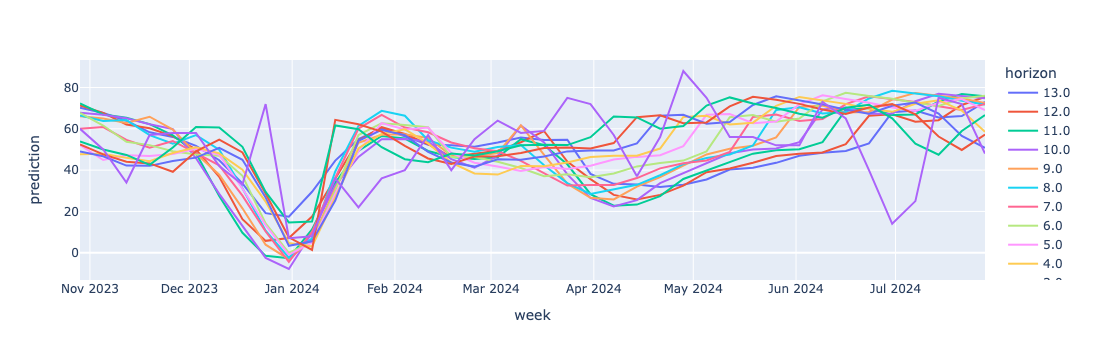

In [70]:
visualize_results(predictions, "GBCDF")

## Empty Graph

In [71]:
import os
import sys
import logging
import traceback
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import GCNConv
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from time import time
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import optuna
from helper_functions import *


MAIN_PATH = "/dtu/3d-imaging-center/courses/02509/groups/group10/msc-hpc-run/"

# ---------------------------
# Global settings and seeding
# ---------------------------
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
pl.seed_everything(42)

# Global paths and constants
IMPORTS_PATH = os.path.join(MAIN_PATH, "data/import-volume.csv")
ADJACENCY_MATRIX = pd.read_parquet(os.path.join(MAIN_PATH, "data/adjacency-matrix.parquet"))
BOOKINGS_PATH = os.path.join(MAIN_PATH, "data/bookings_data.pkl")

# Global hyperparameters and settings
use_validation = False  
NODE_FEATURES = 21        # 6 from volume/week encoding + 13 booking features
TIME_WINDOW_SIZE = 13
LOADERS_WOKRES = 4

MIN_HORIZON = 1
MAX_HORIZON = 14

EARLY_STOP_PATIENCE = 10
EARLY_STOP_DELTA = 0.001

DIRECT_HORIZONS_TO_PREDICT = 13

# ---------------------------
# Data and Graph Preparation
# ---------------------------
def get_import_data():
    """Load and pivot the import volume data."""
    try:
        import_data = pd.read_csv(IMPORTS_PATH)
        import_data["week"] = pd.to_datetime(import_data["week"])
        import_data["pool"] = import_data["pool"].astype("str")
        import_data["volume"] = import_data["import"].astype("float")
        import_data.drop(columns=["import"], inplace=True)
        import_data = import_data.sort_values("week")
        import_data = import_data.loc[
            (import_data.week >= pd.to_datetime("2017-05-01")) &
            (import_data.week <= pd.to_datetime("2024-10-20"))
        ]
        logging.info(f"Imports data range from {import_data['week'].min().strftime('%Y-%m-%d')} "
                     f"to {import_data['week'].max().strftime('%Y-%m-%d')}")
        import_data = import_data.pivot(index='week', columns='pool', values='volume').T
        import_data = import_data.fillna(0)
        return import_data
    except Exception as e:
        logging.error("Error in get_import_data(): " + str(e))
        raise

def get_graph_structure(threshold, a):
    """Construct the graph structure (edge_index and edge_weights) from the adjacency matrix."""
    try:
        a = a.reset_index(drop=True)
        a.columns = range(a.shape[1])
        a = a.where(pd.notnull(a), a.T)
        a = a.to_numpy()
        a_filtered = (a > threshold).astype(np.int32)
        edge_index = torch.nonzero(torch.tensor(a_filtered, dtype=torch.long), as_tuple=False).t()
        edge_weights = []
        for e in edge_index.numpy().T:
            distance = a[e[0], e[1]]
            edge_weights.append(distance)
        edge_weights = torch.tensor(edge_weights, dtype=torch.float32)
        # epsilon = 1e-8
        # edge_weights = 10 / (edge_weights + epsilon)
        return edge_index, edge_weights
    except Exception as e:
        logging.error("Error in get_graph_structure(): " + str(e))
        raise

def prepare_data(use_validation, prediction_horizon, batch_size):
    """Preprocess the data, create features, and return DataLoaders."""
    try:
        data = get_import_data()
        bookings = pickle.load(open(BOOKINGS_PATH, "rb"))
        logging.info(f"Bookings data range from {min(bookings.keys())} to {max(bookings.keys())}")

        if use_validation:
            val_weeks = 52
            test_weeks = 77
            train_weeks = data.shape[1] - val_weeks - test_weeks
        else:
            test_weeks = 77
            train_weeks = data.shape[1] - test_weeks

        volume_tensor = torch.tensor(data.values, dtype=torch.float32)
        week_numbers = data.columns.to_series().dt.isocalendar().week.astype(np.float32).values

        if use_validation:
            train_volume = volume_tensor[:, :train_weeks]
            val_volume = volume_tensor[:, train_weeks: train_weeks + val_weeks]
            test_volume = volume_tensor[:, train_weeks + val_weeks: train_weeks + val_weeks + test_weeks]
        else:
            train_volume = volume_tensor[:, :train_weeks]
            test_volume = volume_tensor[:, train_weeks: train_weeks + test_weeks]

        # Normalize volume using training statistics
        train_mean = train_volume.mean(dim=1, keepdim=True)
        train_std = train_volume.std(dim=1, keepdim=True) + 1e-6
        train_volume_norm = (train_volume - train_mean) / train_std
        if use_validation:
            val_volume_norm = (val_volume - train_mean) / train_std
        test_volume_norm = (test_volume - train_mean) / train_std

        # Create week encoding features
        week_numbers_tensor = torch.tensor(week_numbers, dtype=torch.float32)
        sin_week = torch.sin(2 * np.pi * week_numbers_tensor / 52)
        cos_week = torch.cos(2 * np.pi * week_numbers_tensor / 52)
        holiday_ohe = (week_numbers_tensor == 52).long()
        weeks_to_holiday = (52 - week_numbers_tensor) % 52
        weeks_from_holiday = (week_numbers_tensor - 52) % 52

        def split_features(feature, n_train, n_val, n_test):
            train_feat = feature[:n_train]
            val_feat = feature[n_train: n_train + n_val]
            test_feat = feature[n_train + n_val: n_train + n_val + n_test]
            return train_feat, val_feat, test_feat

        if use_validation:
            train_sin, val_sin, test_sin = split_features(sin_week, train_weeks, val_weeks, test_weeks)
            train_cos, val_cos, test_cos = split_features(cos_week, train_weeks, val_weeks, test_weeks)
            train_holiday, val_holiday, test_holiday = split_features(holiday_ohe, train_weeks, val_weeks, test_weeks)
            train_to, val_to, test_to = split_features(weeks_to_holiday, train_weeks, val_weeks, test_weeks)
            train_from, val_from, test_from = split_features(weeks_from_holiday, train_weeks, val_weeks, test_weeks)
        else:
            train_sin = sin_week[:train_weeks]
            test_sin = sin_week[train_weeks: train_weeks + test_weeks]
            train_cos = cos_week[:train_weeks]
            test_cos = cos_week[train_weeks: train_weeks + test_weeks]
            train_holiday = holiday_ohe[:train_weeks]
            test_holiday = holiday_ohe[train_weeks: train_weeks + test_weeks]
            train_to = weeks_to_holiday[:train_weeks]
            test_to = weeks_to_holiday[train_weeks: train_weeks + test_weeks]
            train_from = weeks_from_holiday[:train_weeks]
            test_from = weeks_from_holiday[train_weeks: train_weeks + test_weeks]

        def create_week_feature_tensor(week_feat, num_nodes):
            if week_feat.dim() == 1:
                week_feat = week_feat.unsqueeze(1)
            return week_feat.unsqueeze(0).repeat(num_nodes, 1, 1)

        num_nodes = 16  # Hard-coded based on the data
        train_sin_feat = create_week_feature_tensor(train_sin, num_nodes)
        train_cos_feat = create_week_feature_tensor(train_cos, num_nodes)
        train_holiday_feat = create_week_feature_tensor(train_holiday, num_nodes)
        train_to_feat = create_week_feature_tensor(train_to, num_nodes)
        train_from_feat = create_week_feature_tensor(train_from, num_nodes)

        if use_validation:
            val_sin_feat = create_week_feature_tensor(val_sin, num_nodes)
            val_cos_feat = create_week_feature_tensor(val_cos, num_nodes)
            val_holiday_feat = create_week_feature_tensor(val_holiday, num_nodes)
            val_to_feat = create_week_feature_tensor(val_to, num_nodes)
            val_from_feat = create_week_feature_tensor(val_from, num_nodes)
            test_sin_feat = create_week_feature_tensor(test_sin, num_nodes)
            test_cos_feat = create_week_feature_tensor(test_cos, num_nodes)
            test_holiday_feat = create_week_feature_tensor(test_holiday, num_nodes)
            test_to_feat = create_week_feature_tensor(test_to, num_nodes)
            test_from_feat = create_week_feature_tensor(test_from, num_nodes)
        else:
            test_sin_feat = create_week_feature_tensor(test_sin, num_nodes)
            test_cos_feat = create_week_feature_tensor(test_cos, num_nodes)
            test_holiday_feat = create_week_feature_tensor(test_holiday, num_nodes)
            test_to_feat = create_week_feature_tensor(test_to, num_nodes)
            test_from_feat = create_week_feature_tensor(test_from, num_nodes)

        train_volume_feat = train_volume_norm.unsqueeze(2)
        if use_validation:
            val_volume_feat = val_volume_norm.unsqueeze(2)
        test_volume_feat = test_volume_norm.unsqueeze(2)

        if use_validation:
            train_data_combined = torch.cat([
                train_volume_feat, train_sin_feat, train_cos_feat,
                train_holiday_feat, train_to_feat, train_from_feat
            ], dim=2)
            val_data_combined = torch.cat([
                val_volume_feat, val_sin_feat, val_cos_feat,
                val_holiday_feat, val_to_feat, val_from_feat
            ], dim=2)
            test_data_combined = torch.cat([
                test_volume_feat, test_sin_feat, test_cos_feat,
                test_holiday_feat, test_to_feat, test_from_feat
            ], dim=2)
        else:
            train_data_combined = torch.cat([
                train_volume_feat, train_sin_feat, train_cos_feat,
                train_holiday_feat, train_to_feat, train_from_feat
            ], dim=2)
            test_data_combined = torch.cat([
                test_volume_feat, test_sin_feat, test_cos_feat,
                test_holiday_feat, test_to_feat, test_from_feat
            ], dim=2)

        # Process booking features
        booking_list = []
        for date in data.columns:
            booking_df = bookings[date.strftime("%Y-%m-%d")]
            booking_list.append(booking_df.values)
        booking_array = np.stack(booking_list, axis=1)
        bookings_tensor = torch.tensor(booking_array, dtype=torch.float32)

        if use_validation:
            train_bookings = bookings_tensor[:, :train_weeks, :]
            val_bookings = bookings_tensor[:, train_weeks: train_weeks + val_weeks, :]
            test_bookings = bookings_tensor[:, train_weeks + val_weeks: train_weeks + val_weeks + test_weeks, :]
        else:
            train_bookings = bookings_tensor[:, :train_weeks, :]
            test_bookings = bookings_tensor[:, train_weeks: train_weeks + test_weeks, :]

        booking_mean = train_bookings.mean(dim=(0, 1), keepdim=True)
        booking_std = train_bookings.std(dim=(0, 1), keepdim=True) + 1e-6
        train_bookings = (train_bookings - booking_mean) / booking_std
        if use_validation:
            val_bookings = (val_bookings - booking_mean) / booking_std
        test_bookings = (test_bookings - booking_mean) / booking_std

        if use_validation:
            train_data_combined = torch.cat([train_data_combined, train_bookings], dim=2)
            val_data_combined = torch.cat([val_data_combined, val_bookings], dim=2)
            test_data_combined = torch.cat([test_data_combined, test_bookings], dim=2)
        else:
            train_data_combined = torch.cat([train_data_combined, train_bookings], dim=2)
            test_data_combined = torch.cat([test_data_combined, test_bookings], dim=2)

        class TimeSeriesDataset(Dataset):
            def __init__(self, data, window_size, horizon):
                self.data = data
                self.window_size = window_size
                self.horizon = horizon  # Now used to predict multiple future steps
                self.num_samples = data.shape[1] - window_size - horizon + 1

            def __len__(self):
                return self.num_samples

            def __getitem__(self, idx):
                x = self.data[:, idx: idx + self.window_size, :].transpose(0, 1)
                # Now y is a sequence of length `horizon` (i.e., 13 time steps)
                y = self.data[:, idx + self.window_size: idx + self.window_size + self.horizon, 0]
                return x, y

        window_size = TIME_WINDOW_SIZE
        train_dataset = TimeSeriesDataset(train_data_combined, window_size, horizon=prediction_horizon)
        test_dataset = TimeSeriesDataset(test_data_combined, window_size, horizon=prediction_horizon)
        if use_validation:
            val_dataset = TimeSeriesDataset(val_data_combined, window_size, horizon=prediction_horizon)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                  pin_memory=True, num_workers=LOADERS_WOKRES)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=LOADERS_WOKRES)
        if use_validation:
            val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, 
                                    pin_memory=True)
        else:
            val_loader = None

        return train_loader, val_loader, test_loader, (train_mean, train_std)
    except Exception as e:
        logging.error("Error in prepare_data(): " + str(e))
        traceback.print_exc()
        raise

def prepare_graph(threshold):
    """Prepare the graph structure (edge_index, edge_weights) using the given threshold."""
    try:
        edge_index, edge_weights = get_graph_structure(threshold, ADJACENCY_MATRIX)
        return edge_index, edge_weights
    except Exception as e:
        logging.error("Error in prepare_graph(): " + str(e))
        raise

# ---------------------------
# Model Definitions
# ---------------------------
class GNNLSTM(nn.Module):
    def __init__(self, in_channels, gnn_hidden, gnn_dropout,
                 lstm_hidden, lstm_layers, lstm_dropout, forecast_horizon):
        super(GNNLSTM, self).__init__()
        self.gnn1 = GCNConv(
            in_channels=in_channels,
            out_channels=gnn_hidden,
        )
        self.gnn2 = GCNConv(
            in_channels=gnn_hidden,
            out_channels=gnn_hidden,
        )
        self.lstm = nn.LSTM(
            input_size=gnn_hidden,
            hidden_size=lstm_hidden,
            batch_first=True,
            num_layers=lstm_layers,
            dropout=lstm_dropout,
        )
        # Now output a vector of length equal to forecast_horizon (i.e., 13 steps)
        self.fc = nn.Linear(lstm_hidden, forecast_horizon)
        
        self.norm1 = nn.LayerNorm(gnn_hidden)
        self.norm2 = nn.LayerNorm(gnn_hidden)
        self.relu = nn.ReLU()
        self.gnn_dropout = gnn_dropout

    def forward(self, x, edge_index, edge_weight=None):
        # x: (batch_size, seq_len, num_nodes, in_channels)
        batch_size, seq_len, num_nodes, _ = x.shape
        device = x.device

        total_graphs = batch_size * seq_len
        x_reshaped = x.reshape(total_graphs, num_nodes, -1)

        E = edge_index.size(1)
        batched_edge_index = edge_index.unsqueeze(0).repeat(total_graphs, 1, 1)
        offsets = (torch.arange(total_graphs, device=device) * num_nodes).view(total_graphs, 1, 1)
        batched_edge_index = batched_edge_index + offsets
        
        
        if E != 0:
            batched_edge_index = batched_edge_index.cpu().numpy()
            edge_index_final = []
            for l in range(batched_edge_index.shape[0]):
                for k in range(E):
                    edge_index_final.append(np.array([batched_edge_index[l, 0, k], batched_edge_index[l, 1, k]]))
            
            batched_edge_index = torch.tensor(np.vstack(edge_index_final), device=device).t().contiguous()
        
        else:
            batched_edge_index = batched_edge_index.reshape(2,0)
            
            
        # Batch edge weights if provided
        if edge_weight is not None:
            batched_edge_weight = edge_weight.unsqueeze(0).repeat(total_graphs, 1)
            batched_edge_weight = batched_edge_weight.reshape(total_graphs * E)
        else:
            batched_edge_weight = None
            
        x_flat = x_reshaped.reshape(total_graphs * num_nodes, -1)

        gnn_out = self.gnn1(x_flat, batched_edge_index, edge_weight=batched_edge_weight)
        gnn_out = self.norm1(gnn_out)
        # gnn_out = self.relu(gnn_out)
        # gnn_out = F.dropout(gnn_out, p=self.gnn_dropout, training=self.training)
        # gnn_out = self.gnn2(gnn_out, batched_edge_index, edge_weight=batched_edge_weight)
        # gnn_out = self.norm2(gnn_out)
        gnn_out = gnn_out.reshape(total_graphs, num_nodes, -1)
        gnn_out = gnn_out.reshape(batch_size, seq_len, num_nodes, -1)

        lstm_input = gnn_out.transpose(1, 2).reshape(batch_size * num_nodes, seq_len, -1)
        lstm_out, _ = self.lstm(lstm_input)
        last_out = lstm_out[:, -1, :]
        pred = self.fc(last_out)
        # Reshape to (batch_size, num_nodes, forecast_horizon)
        pred = pred.reshape(batch_size, num_nodes, -1)
        return pred

class LitGNNLSTM(pl.LightningModule):
    def __init__(self, in_channels, gnn_hidden, gnn_dropout,
                 lstm_hidden, lstm_layers, lstm_dropout, learning_rate, edge_index, edge_weight, forecast_horizon):
        super(LitGNNLSTM, self).__init__()
        self.model = GNNLSTM(in_channels, gnn_hidden, gnn_dropout,
                             lstm_hidden, lstm_layers, lstm_dropout, forecast_horizon)
        self.learning_rate = learning_rate
        self.criterion = nn.MSELoss()
        self.register_buffer("edge_index", edge_index)
        self.register_buffer("edge_weight", edge_weight)

    def forward(self, x):
        return self.model(x, self.edge_index, self.edge_weight)

    def training_step(self, batch, batch_idx):
        x, y = batch  # y now has shape (batch_size, num_nodes, forecast_horizon)
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("test_loss", loss)
        return loss

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=self.learning_rate)

def create_model(edge_index, edge_weight, params):
    """Create the Lightning model using hyperparameters from Optuna."""
    try:
        model = LitGNNLSTM(
            in_channels=NODE_FEATURES,
            gnn_hidden=params["gnn_hidden"],
            gnn_dropout=params["gnn_dropout"],
            lstm_hidden=params["lstm_hidden"],
            lstm_layers=params["lstm_layers"],
            lstm_dropout=params["lstm_dropout"],
            learning_rate=params["learning_rate"],
            edge_index=edge_index,
            edge_weight=edge_weight,
            forecast_horizon=DIRECT_HORIZONS_TO_PREDICT,  # Now predicting 13 steps at once
        )
        return model
    except Exception as e:
        logging.error("Error in create_model(): " + str(e))
        raise


# ---------------------------
# Trainer Setup
# ---------------------------
def create_trainer(max_epochs):
    """Create a PyTorch Lightning Trainer with early stopping and AMP enabled."""
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=EARLY_STOP_DELTA,
        patience=EARLY_STOP_PATIENCE,
        verbose=True,
        mode="min",
    )
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="gpu",
        devices=1,
        precision="16-mixed",
        callbacks=[early_stop_callback],
        log_every_n_steps=1,
        enable_progress_bar=False,
        enable_checkpointing=True,
        logger=True,
        enable_model_summary=False,
        default_root_dir="lightning_gcn/"
    )
    return trainer

with open("../../output/sho/study_results_gcn/sho_gcn_study.pickle", 'rb') as f:
    sho_gcn_study = pickle.load(f)
best_params = sho_gcn_study.trials_dataframe().sort_values("value").head(1)

params = {
    "learning_rate": float(best_params["params_learning_rate"].values[0]),
    "gnn_hidden": int(best_params["params_gnn_hidden"].values[0]),
    "gnn_dropout": 0.0,
    "lstm_hidden": int(best_params["params_lstm_hidden"].values[0]),
    "lstm_dropout": float(best_params["params_lstm_dropout"].values[0]),
    "lstm_layers": int(best_params["params_lstm_layers"].values[0]),
    "graph_threshold": 1.0,
    "batch_size": int(best_params["params_batch_size"].values[0]),
    "epochs": 300,
}

train_loader, val_loader, test_loader, train_statistics = prepare_data(use_validation=use_validation, prediction_horizon=DIRECT_HORIZONS_TO_PREDICT, batch_size=params["batch_size"])
train_mean, train_std = train_statistics
edge_index, edge_weight = prepare_graph(params["graph_threshold"])

model = create_model(edge_index, edge_weight, params)
trainer = create_trainer(max_epochs=params["epochs"])
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for x, y in test_loader:
        preds = model(x)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

all_preds = (all_preds.T * train_std.numpy() + train_mean.numpy()).T
all_targets = (all_targets.T * train_std.numpy() + train_mean.numpy()).T

predictions = create_predictions(all_preds, all_targets)
results_horizon = create_results_horizon(predictions)
results_pool = create_results_pool(predictions)

Seed set to 42
/zhome/a9/1/194879/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30000000000000004 and num_layers=1

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
Metric val_loss improved. New best score: 1.637
Metric val_loss improved by 0.100 >= min_delta = 0.001. New best score: 1.537
Metric val_loss improved by 0.740 >= min_delta = 0.001. New best score: 0.797
Metric val_loss improved by 0.110 >= min_delta = 0.001. New best score: 0.687
Metric val_loss improved by 0.092 >= min_delta = 0.001. New best score: 0.595
Metric val_loss improved by 0.055 >= min_delta = 0.001. New best score: 0.540
Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.

In [72]:
results_horizon

,RMSE,MPE,WMAPE
horizon,,,
1.0,181.287637,-12.337947,16.728340
2.0,177.234845,-11.542063,17.188854
3.0,179.434514,-11.281840,17.383300
4.0,175.551494,-12.004080,17.314566
5.0,175.393400,-9.628365,17.630095
6.0,182.372311,-12.054171,18.678641
7.0,207.041776,-14.783874,20.022179
8.0,214.945752,-15.449705,20.847638
9.0,228.111287,-12.604739,21.484708


In [73]:
results_pool

,RMSE,MPE,WMAPE
pool,,,
GBBFS,35.478042,-34.090365,41.414388
GBBGH,98.393214,-15.573098,18.452791
GBCDF,23.621977,0.618682,35.367905
GBDCT,40.647335,-39.337009,34.926515
GBDPT,66.651444,18.979025,29.385712
GBFXS,733.764374,-17.461790,19.540137
GBGMO,37.366118,-24.716676,25.696374
GBLDS,41.714911,-30.282109,28.902877
GBLGP,336.645533,-9.664974,19.383353


In [74]:
visualize_errors(predictions)

Test RMSE: 210.0989
Test MPE: -13.6280
Test WMAPE: 19.8378
